# MQ Spectrograph Reduction Pipeline Lab
This notebook provides users with a step-by-step guide for data reduction using a pipeline developed for the
Macquarie University Spectrograph.

## Step 1: Import Functions
Run the following code which imports a set of functions and Python packages that are utilised in the following
code. Note that the location of this file should exist in the same directory as the rest of the reduction scripts, as should your Python Notebook.

In [3]:
%run /Users/Jacob/Desktop/mq_spectrograph_final/import_functions.py # Mac example
# %run C:\\Users\\87463547\\Documents\\Physics_data\\import_functions.py # Windows example

Import the following modules. This needs only to be run once, so that your Python notebook has access to these modules which can then be used effectively in the pipeline.

In [ ]:
import sys
!{sys.executable} -m pip install numpy

import sys
!{sys.executable} -m pip install barycorrpy

import sys
!{sys.executable} -m pip install lmfit

import sys
!{sys.executable} -m pip install astroquery

## Step 2: Define Variables
Here we define our path to which the code looks for our input data to be reduced in the pipeline. This can be in a separate directory to the location of this notebook and our reduction scripts.

In [4]:
# path = 'C:\\Users\\87463547\\Documents\\Physics_data\\' # Windows example
path = '/Users/Jacob/Desktop/data_for_mq_final/' # Mac example

Here we set up our data directory by searching for a series of sub-directories, and if they do not exist, generate new sub-directories to which our plots that are generated in the pipeline, are saved to.

In [5]:
## Windows
#if os.path.isdir(path + '\\plots') == False:
#    os.mkdir(path + 'plots')
#save_plots = path + 'plots\\' # added so that we can save the plots to file
#if os.path.isdir(save_plots + '\\order_tracing_plots') == False:
#    os.mkdir(save_plots + 'order_tracing_plots\\')
#save_plots = save_plots + 'order_tracing_plots\\'

## Mac
if os.path.isdir(path + '/plots') == False:
    os.mkdir(path + 'plots')
save_plots = path + 'plots/' # added so that we can save the plots to file
if os.path.isdir(save_plots + 'order_tracing_plots/') == False:
    os.mkdir(save_plots + 'order_tracing_plots/')
save_plots = save_plots + 'order_tracing_plots/'

## Step 3: Calibration Data
Having set up our input directories, and prepared our data for reduction, we want to now input them into the notebook to then be utilised.

There are three 'master' frames that need to be generated: master bias, master dark, and master white frames.

The master bias frame is generally the average (median) of a set of bias frames, which are all taken with a zero exposure time with an absence of incoming light.

The master dark frame is similar to the master bias in that it is generated through the average (median) of a set of dark current frames on the same exposure time. These individual frames differ from bias frames as they are given an exposure or integration time, but are still in the absence of any incoming light. In theory, we need to provide several frames with different exposure times when processing raw data.

Lastly, the master white frame is comprised of an average (median) of a set of white frames. These white frames have a short integration/exposure time but this time, pointed at an evenly illuminated field. The purpose is to record uneven field illumination due to optics for example, and remove this from the raw data.

The master dark is generated second and has the master bias frame subtracted from it. The master white is generated last and has the master bias and master dark frames subtracted from it.

-----------------------------------------------------------------------------------------------------------------

<font color = red> NOTE: that our pipeline currently has a default for the master bias and dark, which are generated as an array of zeros, and the read out noise mask set to an array of ones (multiplied by an integer value).

In [6]:
## use glob.glob to input your data and set them to the appropriate lists
## make sure to check tht your stellar/white/laser lists are importing the right files !!!
## note that the code will have to change depending on the naming convention of the input data
stellar_list = glob.glob(path + 'mq_blackbody*.fits')
laser_list = glob.glob(path + 'mq_etalon*.fits')
white_list = glob.glob(path + 'mq_flat*.fits')

### 3a: IMAGE ORIENTATION/CORRECTION (MAC ONLY)
<font color = red> NOTE: this correction/orientation code is currently only used for operation on a Mac, and if necessary, can be used to orient the images in the correct way. It is also unautomated, as our initial set of MQ simulations are offset by a rotation of 90 degrees in the CW direction. 

In [7]:
stellar_list,white_list,laser_list = orientation_test_unautomated(stellar_list, white_list, laser_list,path=path)

correcting 1 flat frames...


correcting 4 stellar frames...


correcting 1 laser frames...


all frames are in the correct orientation!!!


In [8]:
## input corrected data
## make sure to check that your stellar/white/laser lists are importing the right files !!!
stellar_list = glob.glob(path + 'corrected_mq_blackbody*00.fits')
laser_list = glob.glob(path + 'corrected_mq_etalon.fits')
white_list = glob.glob(path + 'corrected_mq_flat*.fits')

In [9]:
stellar_list

['/Users/Jacob/Desktop/data_for_mq_final/corrected_mq_blackbody3500.fits',
 '/Users/Jacob/Desktop/data_for_mq_final/corrected_mq_blackbody2500.fits',
 '/Users/Jacob/Desktop/data_for_mq_final/corrected_mq_blackbody6500.fits',
 '/Users/Jacob/Desktop/data_for_mq_final/corrected_mq_blackbody4500.fits']

In [10]:
## generates a dummy image of the first .fit file from the stellar_list and returns the shape of that image
dumimg = pyfits.getdata(stellar_list[0])
ny,nx = dumimg.shape

## here we input the gain
## relates the initial number of electrons in a pixel to the number of counts per pixel
## the ratio of these two numbers is the gain
gain = 1 # change this depending on the reported gain of the CCD
gain = [1., 1., 1., 1.] * gain

## setting the master bias to an array of all zeros with the same dimensions as the dummy image created earlier
## similar process for the readout noise mask, but with an array of ones (here set to 3s)
MB = np.zeros(dumimg.shape) # else will they be generating their own? (COULD EXPAND ON THIS)
ronmask = np.ones(dumimg.shape) * 3.

## create (bias-subtracted) master dark frame (units = electrons)
## setting the master dark to an array of all zeros with the same dimensions as the dummy image created earlier
## deletes the value assigned to the dummy image variable
MDS = np.zeros(dumimg.shape)
del dumimg

## create (bias- & dark-subtracted) master white frame and corresponding error array (units = electrons)
MW,err_MW = process_whites(white_list, MB=MB, ronmask=ronmask, MD=MDS, gain=gain, scalable=True, fancy=False,
                           clip=5., savefile=True, saveall=False, diffimg=False, path=path, 
                           debug_level=1, timit=False)

Creating master white frame from 1 fibre flats...
Now processing file: /Users/Jacob/Desktop/data_for_mq_final/corrected_mq_flat.fits


## Step 4: Order Tracing
Here we find the orders 'roughly' and produce plots which show the local maxima and order peaks along the centre column of the CCD. Note that there is similarity between the two plots.

There is also a diagnostic plot that is produced that can be used to check if the fit to the orders are appropriate. If the fit is incorrect, look into where the issue could arise:

The minimum peak is defined as the minimum threshold at which the code looks for the peaks in the centre column of your data. If we set the min_peak too low, it will consider most of, if not all of the peaks in the data, so be weary of setting this to an appropriate value.

The mask threshold is a threshold in terms of ADU below which we mask the particular pixel column. For real observations, you want to make sure that what you trace is actually the order and not just noise which happens towards the edges of the orders (and for edges of chips in cross dispersion direction). Simulations on the other hand, have this value set quite low, even to zero, depending on the SNR and stray light in the real spectra, but all we need is to be satisfied that the fitting is good.

-----------------------------------------------------------------------------------------------------------------

<font color = red> NOTE: the fit of the diagnostic plot could also be affected by the orientation of the master white frame (refer to the orientation code in Step 3 above). It could also be affected by the degree of polynomial used to trace the orders, but the default is set to an appropriate value of 2.

Finding stripes...


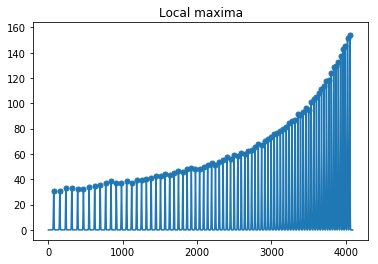

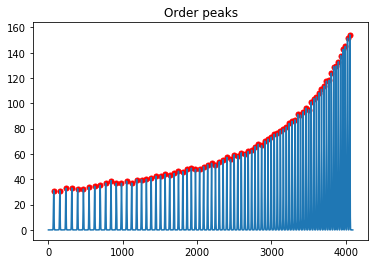

Number of stripes found: 80
Fit polynomial of order 2 to each stripe...


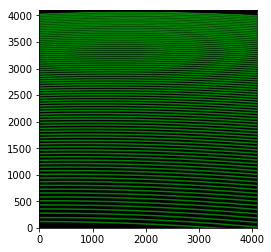

In [11]:
## define your parameters
## min_peak is the minimum threshold at which the code finds the peaks in your data
min_peak = 0.2

## simu refers to whether or not your code is a simulation or not (boolean)
simu=True # simulation
#simu=False # real data

## maskthresh is the threshold at which the code looks to trace the right pixels (orders)
maskthresh = 30

## deg_polynomial is the degree of polynomial used to fit the orders
deg_polynomial = 2

## run the code - will return a list of polynomials and a mask to fit only 'good' pixels
P,tempmask = find_stripes(MW, deg_polynomial=deg_polynomial, min_peak=min_peak, gauss_filter_sigma=3., 
                          simu=simu, debug_level=2, save_plots=save_plots, maskthresh=maskthresh)

## create a dictionary of the polynomial coefficients and corresponding orders, repeat for the mask, save to file
P_id = make_P_id(P)
mask = make_mask_dict(tempmask)
np.save(path + 'P_id.npy', P_id)

### 4a: Extract Stripes
Here we extract the stripes of user-defined width from the science image, centred on the polynomial fits.

In [12]:
## specify the slit height
slit_height = 7

## run the code - will return a dictionary of the extracted stripes, and a dictionary of the indices or
## x-y coordinates of the pixels in the extracted stripes
MW_stripes,MW_indices = extract_stripes(MW, P_id, return_indices=True, timit=True, slit_height=slit_height)

Extracting stripes...
Total time taken for "EXTRACT_STRIPES":  86.76374912261963  seconds


### 4b: Extract Orders
Here we extract the orders (currently only using the quick method of extraction) and return three dictionaries that contain the pixel numbers (in the dispersion direction), the extracted flux, and the uncertainty in the extracted flux (including the photon noise and read-out noise).

-----------------------------------------------------------------------------------------------------------------

    (1) QUICK EXTRACTION: 
        A quick-look reduction of an echelle spectrum, by simply adding up the flux in a pixel column perpendicular to the dispersion direction.
        
    (2) TRAMLINE EXTRACTION:
        Similar to quick extraction, but takes more care in defining the (non-constant) width of the extraction slit. Also uses partial pixels at both ends of the extraction slit.
        
    (3) OPTIMAL EXTRACTION:
        One can choose between three different sub-methods:
        
        (3a) Extract a 1-dim spectrum for each fibre (individual_fibres = True). This is most useful when the fibres are well-separated in cross-dispersion direction) and/or the fibres are significantly offset with respect to each other (in dispersion direction).
        
        (3b) Extract ONE 1-dim spectrum for each object (individual_fibres = False  &&  combined_profile = False). Objects are 'stellar', 'sky', 'laser', and 'thxe'. Calculates "eta's" for each individual fibre, but then adds them up within each respective object.
        
        (3c) Extract ONE 1-dim spectrum (individual_fibres = False  &&  combined_profiles = True). Performs the optimal extraction linear algebra for one combined profile for each object.

In [14]:
## here we need to define fibparms - ONLY if using optimal method of extraction
fibparms = np.load('/Users/Jacob/Desktop/mq_spectrograph_final/data/fibparms_by_ord.npy', 
                   encoding='latin1').item()

#fibparms = 'None' # if using quick method otherwise error will flag in next line of code

In [15]:
## define your parameters
## method: quick, optimal, tramline - which method of extraction?
method = 'quick'

pix,flux,err = extract_spectrum_from_indices(MW, err_MW, MW_indices, method=method, slit_height=slit_height, 
                                             RON=ronmask, savefile=True, filetype='fits', obsname='master_white', 
                                             path=path, timit=True, fibparms=fibparms)
## save this to file so that we can use it for later plots
np.save(path + 'flux.npy', flux) 

ATTENTION: This routine works fine, but consider using "quick_extract", as it is a factor of ~2 faster...
Time taken for quick-look extraction of order_02: 0.20151996612548828 seconds
Time taken for quick-look extraction of order_03: 0.19391703605651855 seconds
Time taken for quick-look extraction of order_04: 0.22512412071228027 seconds
Time taken for quick-look extraction of order_05: 0.20920991897583008 seconds
Time taken for quick-look extraction of order_06: 0.22794604301452637 seconds
Time taken for quick-look extraction of order_07: 0.2384171485900879 seconds
Time taken for quick-look extraction of order_08: 0.32024288177490234 seconds
Time taken for quick-look extraction of order_09: 0.20982122421264648 seconds
Time taken for quick-look extraction of order_10: 0.2036430835723877 seconds
Time taken for quick-look extraction of order_11: 0.2655167579650879 seconds
Time taken for quick-look extraction of order_12: 0.20725011825561523 seconds
Time taken for quick-look extraction of

## Step 5: Process Science Images
Process your input stellar data and use the quick extraction method to produce extracted science images. These are then used for analysis through raw spectra plots, and can also be used to apply a wavelength solution to to calculate a wavelength-calibrated spectrum.

This process may take a few minutes depending on the amount of data.

In [16]:
## define your parameters
## method: quick, optimal, tramline - which method of extraction?
ext_method = 'quick'

dum = process_science_images(stellar_list, P_id, mask=mask, sampling_size=25, slit_height=slit_height, 
                             gain=gain, MB=MB, ronmask=ronmask, MD=MDS, scalable=True, saveall=False,
                             path=path, ext_method=ext_method, offset='True', slope='True', fibs='single', 
                             from_indices=True, timit=True, simu=simu, fibparms=fibparms)

Extracting stellar spectrum 1/4
Time elapsed: 2.4 seconds
Extracting stripes...
Total time taken for "EXTRACT_STRIPES":  92.53180527687073  seconds
ATTENTION: This routine works fine, but consider using "quick_extract", as it is a factor of ~2 faster...
Time taken for quick-look extraction of order_02: 0.19586586952209473 seconds
Time taken for quick-look extraction of order_03: 0.18915390968322754 seconds
Time taken for quick-look extraction of order_04: 0.20535898208618164 seconds
Time taken for quick-look extraction of order_05: 0.21288704872131348 seconds
Time taken for quick-look extraction of order_06: 0.19156312942504883 seconds
Time taken for quick-look extraction of order_07: 0.21833086013793945 seconds
Time taken for quick-look extraction of order_08: 0.20612812042236328 seconds
Time taken for quick-look extraction of order_09: 0.20248699188232422 seconds
Time taken for quick-look extraction of order_10: 0.1985328197479248 seconds
Time taken for quick-look extraction of order

Time taken for quick-look extraction of order_24: 0.1580982208251953 seconds
Time taken for quick-look extraction of order_25: 0.1637711524963379 seconds
Time taken for quick-look extraction of order_26: 0.16595792770385742 seconds
Time taken for quick-look extraction of order_27: 0.158797025680542 seconds
Time taken for quick-look extraction of order_28: 0.16916394233703613 seconds
Time taken for quick-look extraction of order_29: 0.15761780738830566 seconds
Time taken for quick-look extraction of order_30: 0.15900278091430664 seconds
Time taken for quick-look extraction of order_31: 0.16437387466430664 seconds
Time taken for quick-look extraction of order_32: 0.1637868881225586 seconds
Time taken for quick-look extraction of order_33: 0.1549091339111328 seconds
Time taken for quick-look extraction of order_34: 0.15897107124328613 seconds
Time taken for quick-look extraction of order_35: 0.15861821174621582 seconds
Time taken for quick-look extraction of order_36: 0.1567540168762207 s

Time taken for quick-look extraction of order_47: 0.18068885803222656 seconds
Time taken for quick-look extraction of order_48: 0.17325901985168457 seconds
Time taken for quick-look extraction of order_49: 0.17247986793518066 seconds
Time taken for quick-look extraction of order_50: 0.17038798332214355 seconds
Time taken for quick-look extraction of order_51: 0.16710805892944336 seconds
Time taken for quick-look extraction of order_52: 0.1719498634338379 seconds
Time taken for quick-look extraction of order_53: 0.16788387298583984 seconds
Time taken for quick-look extraction of order_54: 0.16910195350646973 seconds
Time taken for quick-look extraction of order_55: 0.18178629875183105 seconds
Time taken for quick-look extraction of order_56: 0.1731278896331787 seconds
Time taken for quick-look extraction of order_57: 0.174454927444458 seconds
Time taken for quick-look extraction of order_58: 0.17332673072814941 seconds
Time taken for quick-look extraction of order_59: 0.1627299785614013

Time taken for quick-look extraction of order_73: 0.1590890884399414 seconds
Time taken for quick-look extraction of order_74: 0.16381478309631348 seconds
Time taken for quick-look extraction of order_75: 0.16753196716308594 seconds
Time taken for quick-look extraction of order_76: 0.1522810459136963 seconds
Time taken for quick-look extraction of order_77: 0.15570902824401855 seconds
Time taken for quick-look extraction of order_78: 0.14914202690124512 seconds
Time taken for quick-look extraction of order_79: 0.15513181686401367 seconds
Time taken for quick-look extraction of order_80: 0.15650606155395508 seconds
Time taken for quick-look extraction of spectrum: 12.755965948104858 seconds
Extracting stellar spectrum 3/4
Time elapsed: 1.9 seconds
Extracting stripes...
Total time taken for "EXTRACT_STRIPES":  90.4863851070404  seconds
ATTENTION: This routine works fine, but consider using "quick_extract", as it is a factor of ~2 faster...
Time taken for quick-look extraction of order_02

Time taken for quick-look extraction of order_14: 0.2555713653564453 seconds
Time taken for quick-look extraction of order_15: 0.18147873878479004 seconds
Time taken for quick-look extraction of order_16: 0.16882610321044922 seconds
Time taken for quick-look extraction of order_17: 0.15291810035705566 seconds
Time taken for quick-look extraction of order_18: 0.15195584297180176 seconds
Time taken for quick-look extraction of order_19: 0.15517711639404297 seconds
Time taken for quick-look extraction of order_20: 0.15173602104187012 seconds
Time taken for quick-look extraction of order_21: 0.15128111839294434 seconds
Time taken for quick-look extraction of order_22: 0.1556861400604248 seconds
Time taken for quick-look extraction of order_23: 0.15900206565856934 seconds
Time taken for quick-look extraction of order_24: 0.153609037399292 seconds
Time taken for quick-look extraction of order_25: 0.15394902229309082 seconds
Time taken for quick-look extraction of order_26: 0.1556229591369629

Time taken for quick-look extraction of order_37: 0.16510891914367676 seconds
Time taken for quick-look extraction of order_38: 0.1714167594909668 seconds
Time taken for quick-look extraction of order_39: 0.1708211898803711 seconds
Time taken for quick-look extraction of order_40: 0.16284489631652832 seconds
Time taken for quick-look extraction of order_41: 0.1603991985321045 seconds
Time taken for quick-look extraction of order_42: 0.16545677185058594 seconds
Time taken for quick-look extraction of order_43: 0.16655588150024414 seconds
Time taken for quick-look extraction of order_44: 0.16743707656860352 seconds
Time taken for quick-look extraction of order_45: 0.17300200462341309 seconds
Time taken for quick-look extraction of order_46: 0.18171215057373047 seconds
Time taken for quick-look extraction of order_47: 0.16272401809692383 seconds
Time taken for quick-look extraction of order_48: 0.15815520286560059 seconds
Time taken for quick-look extraction of order_49: 0.157987117767333

Time taken for quick-look extraction of order_63: 0.15059685707092285 seconds
Time taken for quick-look extraction of order_64: 0.15532422065734863 seconds
Time taken for quick-look extraction of order_65: 0.1660599708557129 seconds
Time taken for quick-look extraction of order_66: 0.16685199737548828 seconds
Time taken for quick-look extraction of order_67: 0.1562488079071045 seconds
Time taken for quick-look extraction of order_68: 0.1637868881225586 seconds
Time taken for quick-look extraction of order_69: 0.16525697708129883 seconds
Time taken for quick-look extraction of order_70: 0.16520094871520996 seconds
Time taken for quick-look extraction of order_71: 0.1577463150024414 seconds
Time taken for quick-look extraction of order_72: 0.16516399383544922 seconds
Time taken for quick-look extraction of order_73: 0.17034101486206055 seconds
Time taken for quick-look extraction of order_74: 0.15910601615905762 seconds
Time taken for quick-look extraction of order_75: 0.1676461696624755